In [1]:
from utils_dino_final import *
import onnxruntime
import time

def get_onnx_mask_from_bboxes(bboxes, ort_session):

    onnx_coord = np.concatenate([xyxy.reshape(1,2,2) for xyxy in bboxes], axis=0)#[None, :, :]
    onnx_label = np.concatenate([np.array([2,3]).reshape(1,2) for _ in range(bboxes.shape[0])], axis=0).astype(np.float32) #[None, :].astype(np.float32)

    print(onnx_coord.shape)
    print(onnx_label.shape)

    print(image.shape[:2])

    onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

    onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
    onnx_has_mask_input = np.zeros(1, dtype=np.float32)

    ort_inputs = {
        "image_embeddings": image_embedding,
        "point_coords": onnx_coord,
        "point_labels": onnx_label,
        "mask_input": onnx_mask_input,
        "has_mask_input": onnx_has_mask_input,
        "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
    }

    masks, _, _ = ort_session.run(None, ort_inputs)
    masks = masks > predictor.model.mask_threshold
    print(masks.shape)

    return masks

final text_encoder_type: bert-base-uncased


Getting wall mask from  D:\3d-recon\datasets\ASARoomImage\b01.jpg


wall_bboxes [[6.7338000e+02 7.2439575e-01 9.9824670e+02 6.6525513e+02]
 [3.5033905e+02 3.3968280e+02 6.7527899e+02 6.3357855e+02]
 [3.5200616e+02 2.6283264e-01 6.7526276e+02 2.5938544e+02]]
wall_selected_points [[843, 327], [591, 534], [512, 128]]
RUG:  0
No overlap
RUG BBOX 141.97705 403.7022 348.301 472.78925
FLOOR BBOX 223.62623596191406 629.5581665039062 705.8456420898438 667.3991088867188
floor_bboxes [[224.62624 630.55817 704.84564 666.3991 ]]
floor_selected_points [[447, 654]]
rug_bboxes []
rug_to_floor_indices []
DONE GETTING BBOXES 2.5954952239990234
(667, 1000, 3)
DONE SAM EMBEDDING 6.6294872760772705
(3, 2, 2)
(3, 2)
(667, 1000)
(3, 1, 667, 1000)
(1, 2, 2)
(1, 2)
(667, 1000)
(1, 1, 667, 1000)
(1, 667, 1000)
[[843 327]]
(1, 667, 1000)
[[591 534]]
(1, 667, 1000)
[[512 128]]


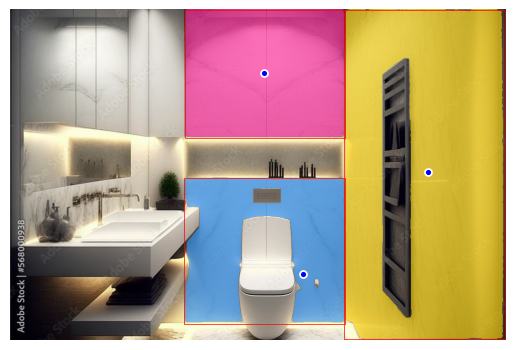

[[447 654]]


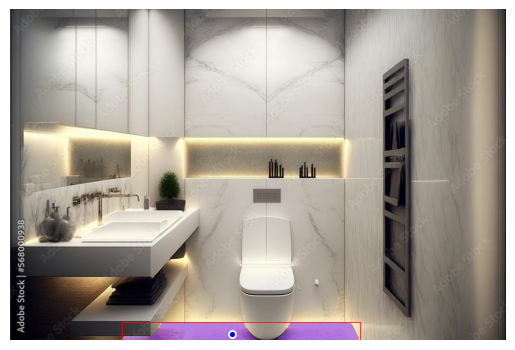

In [ ]:
start_time = time.time()

FOLDER_PATH = r"D:\3d-recon\datasets\ASARoomImage"

OUTPUT_FOLDER_PATH = r"D:\3d-recon\Grounded-Segment-Anything\v1_final_output"

for IMAGE_NAME in os.listdir(FOLDER_PATH):

  SOURCE_IMAGE_PATH = os.path.join(FOLDER_PATH, IMAGE_NAME)

  wall_bboxes, wall_selected_points = get_wall_bboxes_points(SOURCE_IMAGE_PATH)

  print("wall_bboxes", wall_bboxes)
  print("wall_selected_points", wall_selected_points)

  (floor_bboxes, 
  floor_selected_points, 
  rug_bboxes,
  rug_to_floor_indices) = get_floor_bboxes_points_with_rug(SOURCE_IMAGE_PATH)

  print("floor_bboxes", floor_bboxes)
  print("floor_selected_points", floor_selected_points)

  print("rug_bboxes", rug_bboxes)
  print("rug_to_floor_indices", rug_to_floor_indices)


  output = {'wall_bboxes': wall_bboxes,
        'wall_selected_points':wall_selected_points,
        'floor_bboxes':floor_bboxes,
        'floor_selected_points': floor_selected_points,
        'rug_bboxes': rug_bboxes,
        'rug_to_floor_indices':rug_to_floor_indices}

  print("DONE GETTING BBOXES", time.time()-start_time)



  image = cv2.imread(SOURCE_IMAGE_PATH)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  print(image.shape)

  checkpoint = r"./sam_vit_h_4b8939.pth"

  model_type = "vit_h"
  sam = sam_model_registry[model_type](checkpoint=checkpoint)


  sam.to(device='cuda')
  predictor = SamPredictor(sam)
  predictor.set_image(image)
  image_embedding = predictor.get_image_embedding().cpu().numpy()

  np.save("image_embedding_vith.npy", image_embedding)

  print("DONE SAM EMBEDDING", time.time()-start_time)


  onnx_model_path = "sam_onnx_vith_batch.onnx"
  ort_session = onnxruntime.InferenceSession(onnx_model_path)
  wall_masks = get_onnx_mask_from_bboxes(wall_bboxes, ort_session)

  ort_session = onnxruntime.InferenceSession(onnx_model_path)
  floor_masks = get_onnx_mask_from_bboxes(floor_bboxes, ort_session)

  rug_masks = []
  if len(rug_bboxes)>0:
    ort_session = onnxruntime.InferenceSession(onnx_model_path)
    rug_masks = get_onnx_mask_from_bboxes(rug_bboxes, ort_session)

  # Step 1: Convert to uint8 (0 and 255)
  mask_uint8 = (wall_masks[0].squeeze() * 255).astype(np.uint8)  # shape becomes (2657, 1920)


  plt.imshow(image)
  for mask, bbox, point in zip(wall_masks, wall_bboxes, np.array(wall_selected_points)):
      print(mask.shape)
      show_mask(mask, plt.gca())
      show_box(bbox, plt.gca())
      show_points(np.array([point]), labels=np.array([1]), ax=plt.gca())
  plt.axis('off')
  plt.savefig(os.path.join(OUTPUT_FOLDER_PATH,f"{IMAGE_NAME}_wall.jpg"))
  plt.show()
  

  plt.imshow(image)
  for mask, bbox, point in zip(floor_masks, floor_bboxes, np.array(floor_selected_points)):
      show_mask(mask, plt.gca())
      show_box(bbox, plt.gca())
      show_points(np.array([point]), labels=np.array([1]), ax=plt.gca())
  plt.axis('off')
  plt.savefig(os.path.join(OUTPUT_FOLDER_PATH,f"{IMAGE_NAME}_floor.jpg"))
  plt.show()
  

  if len(rug_masks)>0:
    plt.imshow(image)

    for mask, bbox in zip(rug_masks, rug_bboxes):
        show_mask(mask, plt.gca())
        show_box(bbox, plt.gca())
    plt.axis('off')
    plt.savefig(os.path.join(OUTPUT_FOLDER_PATH,f"{IMAGE_NAME}_rug.jpg"))
    plt.show()
